# **Part 1 ( Spoof Detection )**

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.1 MB/s eta 0:00:00


In [ ]:
!pip install transformers datasets torch torchvision timm sklearn matplotlib

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset, random_split

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datasets import load_dataset
from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import Image


In [ ]:
# Load dataset from Hugging Face
dataset = load_dataset("nguyenkhoa/celeba-spoof-for-face-antispoofing-test")

# Reduce dataset to 20%
subset_size = int(0.2 * len(dataset['test']))
dataset_small = dataset['test'].select(range(subset_size))

print(dataset_small)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/437 [00:00<?, ?B/s]

test-00000-of-00010.parquet:   0%|          | 0.00/496M [00:00<?, ?B/s]

test-00001-of-00010.parquet:   0%|          | 0.00/493M [00:00<?, ?B/s]

test-00002-of-00010.parquet:   0%|          | 0.00/494M [00:00<?, ?B/s]

test-00003-of-00010.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

test-00004-of-00010.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

test-00005-of-00010.parquet:   0%|          | 0.00/499M [00:00<?, ?B/s]

test-00006-of-00010.parquet:   0%|          | 0.00/500M [00:00<?, ?B/s]

test-00007-of-00010.parquet:   0%|          | 0.00/498M [00:00<?, ?B/s]

test-00008-of-00010.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

test-00009-of-00010.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/67170 [00:00<?, ? examples/s]

Dataset({
    features: ['cropped_image', 'labels', 'labelNames'],
    num_rows: 13434
})


In [ ]:
# Load ViT feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

# Define transformation function
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ViT input size
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize([0.5], [0.5])  # Normalize
])

# Custom dataset class
class SpoofDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Attempt to load the image, handling missing or corrupt images
        image = self.dataset[idx]['cropped_image']
        label = self.dataset[idx]['labels']

        if image is None:
            print(f"Warning: Image at index {idx} is missing or corrupted. Skipping.")
            return self.__getitem__((idx + 1) % len(self.dataset))  # Try the next image

        # Convert to RGB
        image = image.convert("RGB")
        image = self.transform(image)

        return image, label


# Create dataset object
spoof_dataset = SpoofDataset(dataset_small, transform)

# Split dataset into train and test sets (80-20 split)
train_size = int(0.8 * len(spoof_dataset))
test_size = len(spoof_dataset) - train_size
train_dataset, test_dataset = random_split(spoof_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
# Load pre-trained ViT model for binary classification
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2  # Binary classification: Real vs. Spoof
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Loss: 0.08047103078362332
Epoch 2/10, Loss: 0.01545810258193385
Epoch 3/10, Loss: 0.006073305192590591
Epoch 4/10, Loss: 0.00981133329159569
Epoch 5/10, Loss: 0.006445981419390245
Epoch 6/10, Loss: 0.0007435950229548672
Epoch 7/10, Loss: 0.0004986488604897334
Epoch 8/10, Loss: 0.00034642744382532936
Epoch 9/10, Loss: 0.00024183500969835828
Epoch 10/10, Loss: 0.00016914722194390683


In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.9963
Precision: 0.9963
Recall: 0.9984
F1-score: 0.9974


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import os

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def predict_image(image_path):
    if not os.path.exists(image_path):
        return f"Error: File {image_path} not found."

    try:
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)

        model.eval()
        with torch.no_grad():
            output = model(image).logits
            probabilities = torch.nn.functional.softmax(output, dim=1)
            confidence, prediction = torch.max(probabilities, dim=1)

        return f"{'Real' if prediction.item() == 0 else 'Spoof'} (Confidence: {confidence.item():.2f})"

    except Exception as e:
        return f"Error processing {image_path}: {str(e)}"


# Paths to test images
real_photo_path = "/content/real_img.jpg"
spoof_photo_path = "/content/spoof_image.png"

# Predict and print results
print("Real Photo Prediction:", predict_image(real_photo_path))
print("Spoof Photo Prediction:", predict_image(spoof_photo_path))

Real Photo Prediction: Real (Confidence: 0.92)
Spoof Photo Prediction: Spoof (Confidence: 1.00)


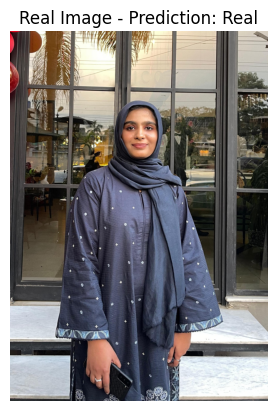

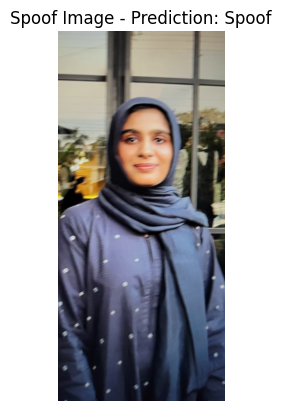

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

def show_image(image_path, title):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)
    plt.show()

# Test with dataset images
show_image("real_img.jpg", "Real Image - Prediction: Real")
show_image("spoof_img.jpg", "Spoof Image - Prediction: Spoof")

# **Part 2: AI-Powered Visual Search**

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.3 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-oeln_3ir
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-oeln_3ir
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
pip install torch torchvision clip-by-openai matplotlib requests tqdm zipfile36

INFO: pip is looking at multiple versions of clip-by-openai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of clip-by-openai to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://p

In [ ]:
import os
import torch
import clip
import requests
import zipfile
import json
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

Download COCO Dataset (val2017 images and annotations)

In [ ]:
# URLs of the dataset
coco_images_url = "http://images.cocodataset.org/zips/val2017.zip"
coco_annotations_url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"

# Define paths
data_dir = "./coco_data"
os.makedirs(data_dir, exist_ok=True)
images_zip = os.path.join(data_dir, "val2017.zip")
annotations_zip = os.path.join(data_dir, "annotations_trainval2017.zip")

In [ ]:
# Function to download files
def download_file(url, save_path):
    if not os.path.exists(save_path):
        print(f"Downloading {url}...")
        response = requests.get(url, stream=True)
        with open(save_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    file.write(chunk)
        print(f"Saved to {save_path}")

# Download images and annotations
download_file(coco_images_url, images_zip)
download_file(coco_annotations_url, annotations_zip)

# Extract files
def extract_zip(file_path, extract_to):
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

extract_zip(images_zip, data_dir)
extract_zip(annotations_zip, data_dir)

Saved to ./coco_data/val2017.zip
Saved to ./coco_data/annotations_trainval2017.zip


Load CLIP model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 99.6MiB/s]


Load COCO Images

In [ ]:
import os
from tqdm import tqdm

# Path to COCO images
image_dir = os.path.join(data_dir, "val2017")
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".jpg")]

# Encode all images
image_features = []
all_images = []

with torch.no_grad():
    for image_path in tqdm(image_files[:3000]):
        image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
        feature = model.encode_image(image)
        image_features.append(feature)
        all_images.append(image_path)

# Convert to tensor
image_features = torch.cat(image_features)
image_features /= image_features.norm(dim=-1, keepdim=True)

100%|██████████| 3000/3000 [11:59<00:00,  4.17it/s]


Perform Similarity Search

In [ ]:
import numpy as np

# Define the text query
text_query = ["A person riding a horse"]
text_tokens = clip.tokenize(text_query).to(device)

# Encode text query
with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Ensure features are normalized
image_features = image_features / image_features.norm(dim=-1, keepdim=True)
text_features = text_features / text_features.norm(dim=-1, keepdim=True)

# Compute cosine similarity correctly
similarities = (image_features @ text_features.T).squeeze(1)  # Ensure correct dimensions
top_indices = similarities.argsort(descending=True)[:5]  # Get top 5 matches
print("Similarity scores:", similarities[:10])

# Get top 5 similar images
top_images = [all_images[idx] for idx in top_indices]
top_scores = [similarities[idx].item() for idx in top_indices]

Similarity scores: tensor([0.2155, 0.1721, 0.1179, 0.2218, 0.1741, 0.1875, 0.1117, 0.2453, 0.1273,
        0.1917])


Display Results

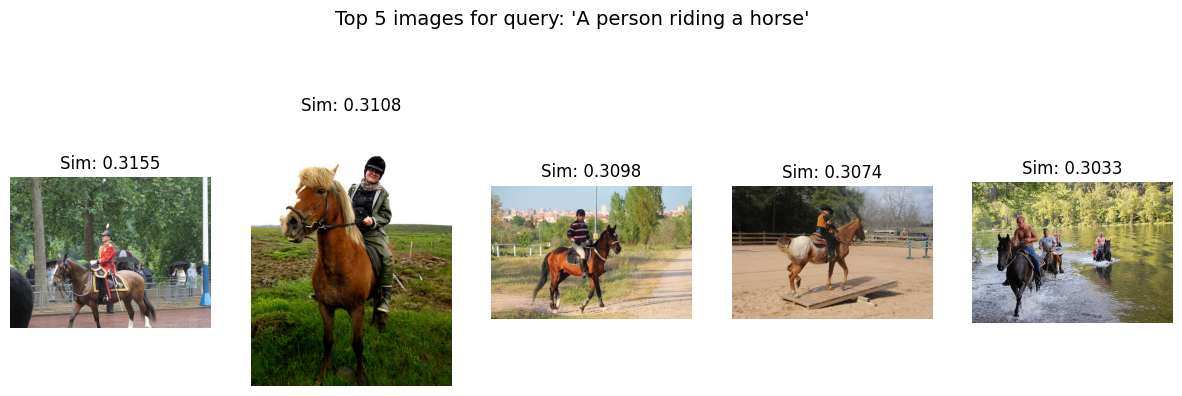

In [ ]:
import matplotlib.pyplot as plt

# Display images with similarity scores
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
fig.suptitle(f"Top 5 images for query: '{text_query[0]}'", fontsize=14)

for i, ax in enumerate(axes):
    img = Image.open(top_images[i])
    ax.imshow(img)
    ax.set_title(f"Sim: {top_scores[i]:.4f}")
    ax.axis("off")

plt.show()


# Part 3: Stable Diffusion

In [ ]:
import torch
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image
import matplotlib.pyplot as plt

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Load Stable Diffusion Model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16 if device == "cuda" else torch.float32)
pipe.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionImg2ImgPipeline {
  "_class_name": "StableDiffusionImg2ImgPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

Load Input Image

In [ ]:
input_image = Image.open("/content/lion.jpg").convert("RGB")
input_image = input_image.resize((512, 512))

Prompt Engineering - Testing Different Styles

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

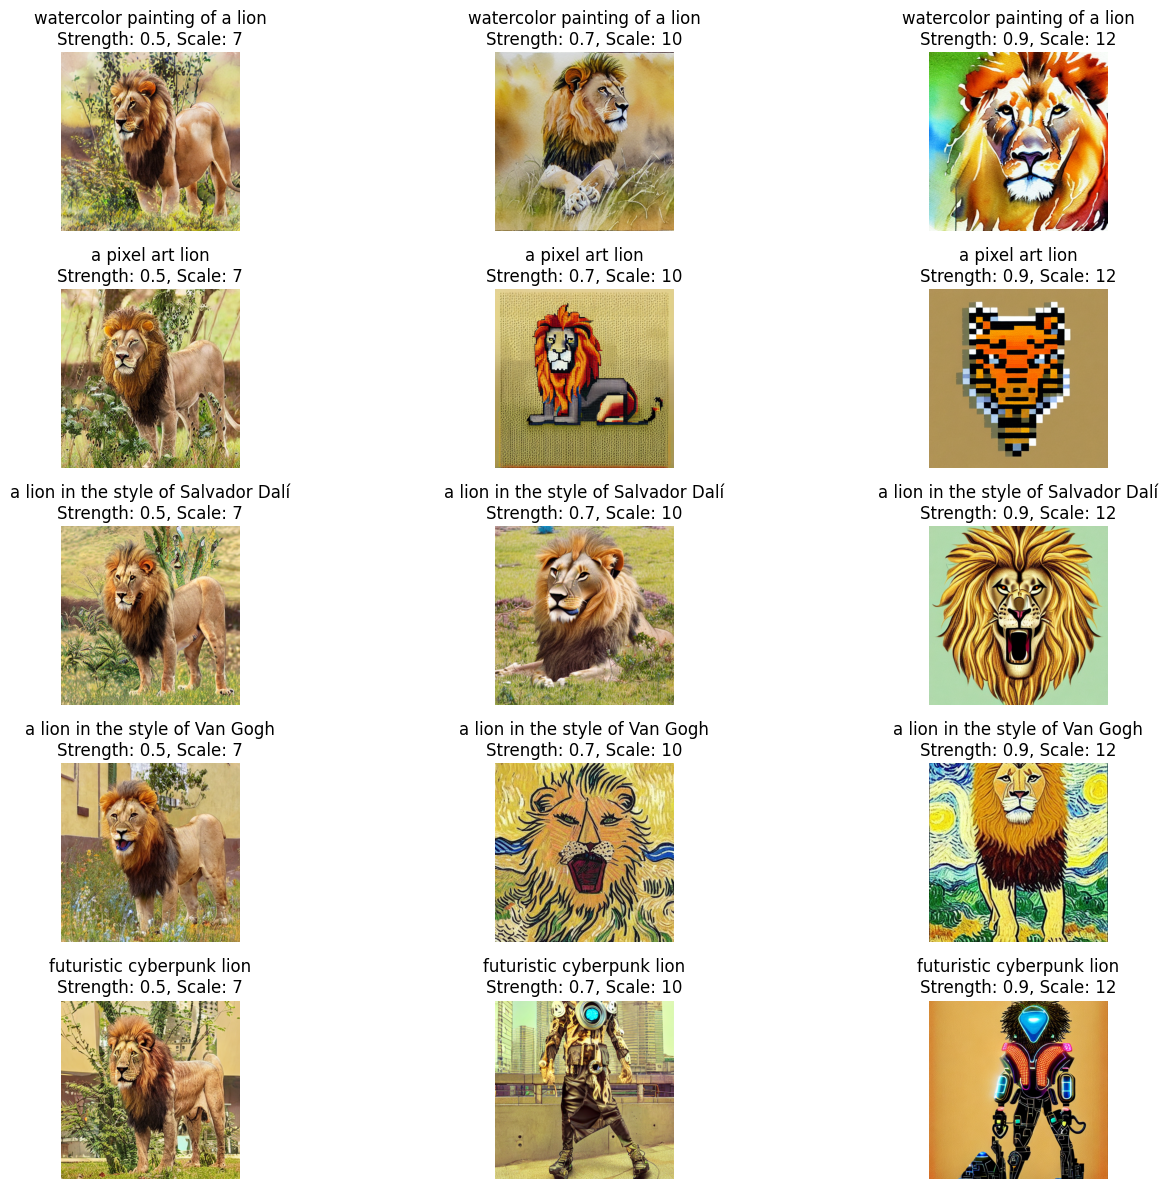

In [ ]:
prompts = [
    "watercolor painting of a lion",
    "a pixel art lion",
    "a lion in the style of Salvador Dalí",
    "a lion in the style of Van Gogh",
    "futuristic cyberpunk lion"
]

# Experiment with Strength & Guidance Scale
experiment_params = [
    {"strength": 0.5, "guidance_scale": 7, "steps": 50},
    {"strength": 0.7, "guidance_scale": 10, "steps": 75},
    {"strength": 0.9, "guidance_scale": 12, "steps": 100}
]

# Generate and Display Results
fig, axes = plt.subplots(len(prompts), len(experiment_params), figsize=(15, 12))

for row, prompt in enumerate(prompts):
    for col, params in enumerate(experiment_params):
        output = pipe(
            prompt=prompt,
            image=input_image,
            strength=params["strength"],
            guidance_scale=params["guidance_scale"],
            num_inference_steps=params["steps"]
        ).images[0]

        axes[row, col].imshow(output)
        axes[row, col].axis("off")
        axes[row, col].set_title(f"{prompt}\nStrength: {params['strength']}, Scale: {params['guidance_scale']}")

plt.tight_layout()
plt.show()
